In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
scale = 1
rod_length = 0.07244622391567243 * scale
width = rod_length / 20 * 10 
thickness = width / 10 * 0.35 
print(width, thickness)
io = InputOrganizer('kleinbottle_projected_{}'.format(scale), thickness, width, weaving_dir)

0.036223111957836215 0.0012678089185242675


In [7]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [8]:
rw = 3
sw = 10

In [9]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width = False, width_scale = [0.5, 1.5])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [10]:
curved_linkage.setExtendedDoFsPSRL(np.load('../../nature_paper_experiments/figure_3/klein_bottle_optimized_dof_23062020.npy'))

In [11]:
curved_linkage.attraction_weight = 1e-5

In [12]:
curved_linkage.energy()

0.0005597063020328109

In [13]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [14]:
OPTS.niter = 10000

In [15]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.000559706	0.51008	0.51008	1	1
1	3.85284e-05	0.0248422	0.0248422	1	1
2	2.55716e-05	0.00641415	0.00641415	1	1
3	2.1627e-05	0.00313652	0.00313652	1	1
4	1.89992e-05	0.00169692	0.00169692	1	1
5	1.6954e-05	0.000978834	0.000978834	1	1
6	1.534e-05	0.000600501	0.000600501	1	1
7	1.41356e-05	0.000402305	0.000402305	1	1
8	1.32914e-05	0.000362327	0.000362327	1	1
9	1.27155e-05	0.000413444	0.000413444	1	1
10	1.23303e-05	0.000382133	0.000382133	1	1
11	1.20861e-05	0.000241624	0.000241624	1	1
12	1.19451e-05	0.000198017	0.000198017	1	1
13	1.18729e-05	0.000171485	0.000171485	1	1
14	1.18403e-05	0.000137635	0.000137635	1	1
15	1.18268e-05	8.99681e-05	8.99681e-05	1	1
16	1.18219e-05	4.67741e-05	4.67741e-05	1	0
17	1.182e-05	0.000112854	0.000112854	1	0
18	1.182e-05	1.33407e-07	1.33407e-07	0.5	0
19	1.182e-05	1.74314e-06	1.74314e-06	1	0
20	1.182e-05	9.73158e-08	9.73158e-08	1	0
21	1.182e-05	1.00842e-06	1.00842e-06	1	0
22	1.182e-05	4.63064e-09	4.63064e-09	1	0


In [16]:
curved_linkage.energy()

1.182001721225077e-05

In [17]:
from structural_analysis import weavingCrossingForceMagnitudes

In [18]:
cfm = weavingCrossingForceMagnitudes(curved_linkage, True)

In [19]:
np.argsort(cfm[:, 0])

array([328,  75, 234,  10,  16, 470, 178, 334,  81, 229, 235, 502, 534,
       216, 312, 329, 437, 507, 233, 406, 186, 532, 212, 403,  76,  74,
       471, 440, 505, 438, 405, 283,  78, 435, 187,  80, 184, 231, 504,
         9, 291, 318, 333,  11,  17, 335, 183, 331, 140, 225,  15, 316,
       452, 107, 177, 192, 537, 399, 191, 160, 531, 232, 473, 175, 197,
       138, 103,  79,   8, 469,  71, 176, 330,  13, 295, 313,   6, 398,
       174, 237,  72, 538, 322, 122, 236, 179, 172, 529,  77,  42,   7,
       271, 337, 282, 434, 265, 518, 238,  69, 308, 474, 240, 269,  44,
       338, 230, 332, 310,  14, 480, 508,  82, 196,  12, 360, 379,  73,
       109, 433, 478, 451, 228, 163, 166, 336, 510, 321, 134,   4, 443,
       472, 164, 165, 512, 449, 226, 181, 188,  19, 535, 327, 104, 135,
       362,  60, 402, 441, 293, 180, 442, 126, 119,  20, 404, 408, 239,
       326, 506, 320,  70, 314, 217,  63,  18, 468, 466, 385, 453, 444,
       366, 132, 491, 382, 359, 195, 221, 106, 401, 287, 123, 37

In [20]:
cfm[:, 0][260]

6.454942323397333e-07

### Deactivate Crossing

In [21]:
import deactivate_crossing_helper
importlib.reload(deactivate_crossing_helper)
from deactivate_crossing_helper import (write_deactivated_linkage, copy_over_under, get_segment_index_from_joints, get_angle_from_kappa, get_kappa_from_angle, no_resample_deactivation, resample_deactivation, get_neighbors)

In [28]:
deactive_index = 260

In [29]:
def create_deactivated_linkage(original_linkage, deactive_index, original_model_name, deactivated_model_name):
    ju = original_linkage.joint(deactive_index)
    nbs = ju.neighbors()
    deactive_vertex_map = [i if i < deactive_index else i - 1 for i in range(original_linkage.numJoints())]
    write_deactivated_linkage(original_model_name, deactivated_model_name, deactive_index, deactive_vertex_map, nbs)
    
    with so(): deactivate_curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = deactivated_model_name, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=elastic_rods.InterleavingType.weaving, use_constant_width = False, width_scale = [0.5, 1.5])
    deactivate_curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    deactivate_curved_linkage.attraction_weight = 1e-5

#     Copy the over under assignment from the original model since BFS will not find a perfect over under in the new topology
    copy_over_under(deactivate_curved_linkage, original_linkage, deactive_vertex_map, deactive_index)
    deactivate_curved_linkage.setDoFs(deactivate_curved_linkage.getDoFs())

    resample_deactivation(deactivate_curved_linkage, original_linkage, deactive_vertex_map, nbs, deactive_index, io)
    return deactivate_curved_linkage, deactive_vertex_map

In [30]:
ju = curved_linkage.joint(deactive_index)
ju.neighbors()

[522, 259, 299, 261]

In [33]:
deactivated_model = ('/'.join(io.MODEL_PATH.split('/')[:-1] + [io.MODEL_NAME + '_deactive_joint_{}.obj'.format(deactive_index)]))

In [34]:
deactivate_linkage, deactive_vertex_map = create_deactivated_linkage(curved_linkage, deactive_index, io.MODEL_PATH, deactivated_model)

1076
1077


In [50]:
import cross_section_scaling
importlib.reload(cross_section_scaling)

<module 'cross_section_scaling' from '../../../../elastic_rods/python/cross_section_scaling.py'>

In [51]:
cross_section = io.RIBBON_CS
width_scale = [0.5, 1.5]
cross_section_scaling.apply_density_based_cross_sections(deactivate_linkage, elastic_rods.CrossSection.construct('rectangle', 2000, 0.3, [cross_section[0], width_scale[0] * cross_section[1]]), elastic_rods.CrossSection.construct('rectangle', 2000, 0.3, [cross_section[0], width_scale[1] * cross_section[1]]))

In [35]:
r = curved_linkage.segment(0).rod

In [36]:
r.material(0)

In [37]:
deactivate_linkage.energy()

0.035608102936615774

In [38]:
curved_linkage.energy()

1.1820017212250771e-05

In [52]:
deactivate_curved_linkage_view = linkage_vis.LinkageViewer(deactivate_linkage)
deactivate_curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [53]:
topColor =[150/255., 150/255., 150/255.]
bottomColor =[79/255., 158/255., 246/255.]
heights = deactivate_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [54]:
deactivate_curved_linkage_view.update(scalarField = colors)

In [55]:
OPTS.niter = 1000

In [56]:
def eqm_callback(prob, i):
    deactivate_curved_linkage_view.update()

In [57]:
elastic_rods.compute_equilibrium(deactivate_linkage, callback = eqm_callback, options = OPTS)

0	1.39041e-05	6.07884e-05	6.07884e-05	1	1
1	1.38888e-05	0.000473729	0.000473729	1	0
2	1.38857e-05	0.000828895	0.000828895	1	1
3	1.38729e-05	0.000119098	0.000119098	0.5	0
4	1.38724e-05	0.0001176	0.0001176	1	0
5	1.38718e-05	1.0718e-05	1.0718e-05	0.25	0
6	1.38717e-05	2.73232e-05	2.73232e-05	1	0
7	1.38716e-05	3.44411e-05	3.44411e-05	1	0
8	1.38715e-05	1.82112e-05	1.82112e-05	0.5	0
9	1.38715e-05	2.36014e-05	2.36014e-05	1	0
10	1.38714e-05	3.4068e-05	3.4068e-05	1	0
11	1.38714e-05	2.20416e-05	2.20416e-05	1	0
12	1.38713e-05	5.70554e-05	5.70554e-05	1	0
13	1.38713e-05	8.40722e-06	8.40722e-06	0.25	0
14	1.38712e-05	2.48409e-05	2.48409e-05	1	0
15	1.38712e-05	1.9287e-05	1.9287e-05	1	0
16	1.38712e-05	2.64648e-05	2.64648e-05	1	0
17	1.38711e-05	1.18392e-05	1.18392e-05	1	0
18	1.38711e-05	3.9449e-05	3.9449e-05	1	0
19	1.38711e-05	2.69208e-06	2.69208e-06	0.5	0
20	1.38711e-05	3.12867e-05	3.12867e-05	1	0
21	1.38711e-05	1.70115e-06	1.70115e-06	0.25	0
22	1.38711e-05	6.08031e-06	6.08031e-06	1	0
23	1.38711e-05	9.9

Min Width  0.018111555978918108
Scale:  276.06683853226144
num seg per rod 120
num seg per rod 120
num seg per rod 120
num seg per rod 119
num seg per rod 120
num seg per rod 120
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 11
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
1439.2450216272073 782.1669701551264
1439.2450216272073 810.2482868687662
1963.9108227300399 810.2482868687662
2212.909278367671 810.2482868687662
2212.909278367671 810.2482868687662
2212.909278367671 810.2482868687662
2212.909278367671 810.2482868687

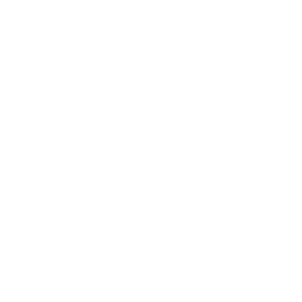

In [58]:
save_path = os.getcwd()
write_all_output(deactivate_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_deactivated', io.RIBBON_NAME + '_deactivated', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

In [59]:
vf = show_selected_joints(deactivate_linkage, [deactive_vertex_map[522], deactive_vertex_map[259], deactive_vertex_map[299], deactive_vertex_map[261]])

In [60]:
deactivate_curved_linkage_view.update(vectorField = vf, scalarField = colors)

In [36]:
# deactivate_curved_linkage_view.show()

In [37]:
# deactivate_linkage_7.energy()